In [2]:
import pandas as pd
import numpy as np
# import feather
import datetime
# import talib
# import mysql.connector
import matplotlib.pyplot as plt
from numpy.random import seed
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix,roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow import keras
import tensorflow as tf
from tensorflow.compat.v1 import set_random_seed
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l1
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import load_model
from imblearn.over_sampling import SMOTE

from py5paisa import FivePaisaClient

2021-08-25 10:19:10.038246: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-25 10:19:10.038304: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
seed(1)
set_random_seed(2)
client = FivePaisaClient(email="52119099", passwd="#bhola@1996", dob="19840101")
client.login()

 10:19:13 | Logged in!!


In [4]:
scriptDf = pd.read_csv('../HistoricalData/NSECashScripts.csv')

In [5]:
symbol = 'banknifty'
end = datetime.datetime.now() - datetime.timedelta(1)
start = end - datetime.timedelta(100)

scode = int(scriptDf[scriptDf['Name']==symbol.upper()]['Scripcode'])
data = client.historical_data('N' , 'C' , scode ,'1m', start ,end)
data.set_index('Datetime' , inplace=True)
data.head()

,Open,High,Low,Close,Volume
Datetime,,,,,
2021-05-17T09:15:00,32450.65,32450.65,32328.15,32383.70,0
2021-05-17T09:16:00,32385.55,32399.15,32351.35,32370.50,0
2021-05-17T09:17:00,32368.80,32437.75,32368.80,32423.75,0
2021-05-17T09:18:00,32418.65,32464.60,32399.30,32459.80,0
2021-05-17T09:19:00,32469.70,32489.40,32448.30,32483.50,0


In [6]:
def getData(symbol,start,end):   
    try:
        scode = int(scriptDf[scriptDf['Name']==symbol.upper()]['Scripcode'])
        data = client.historical_data('N' , 'C' , scode ,'1m', start ,end)
        data.set_index('Datetime' , inplace=True)
        data.index = pd.to_datetime(data.index)
        return data
    except Exception as e:
            print("Error : " , e) 

In [7]:
def balanceData(X,y):
    sm = SMOTE(random_state=2)
    X, y = sm.fit_resample(X, y)    
    return pd.DataFrame(X),pd.Series(y)

In [8]:
end = datetime.datetime.today() - datetime.timedelta(1)
start = end - datetime.timedelta(100)
symbol = 'BANKNIFTY'
#Text formatting
boldTextStart = "\033[1m"
boldTextEnd = "\033[0;0m"

In [9]:
dataset = getData(symbol,start,end)
data = dataset.copy()
data.shape

(26314, 5)

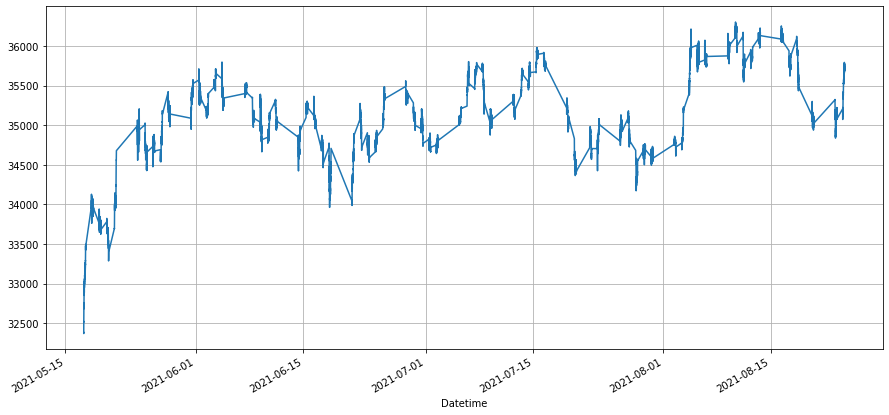

In [10]:
data['Close'].plot(figsize=(15,7))
plt.grid()
plt.show()

In [11]:
initial_balance1 = data.between_time(start_time = '09:16:00', end_time = '10:15:00', include_end = True)
initial_balance2 = data.between_time(start_time = '14:31:00', end_time = '15:30:00', include_end = True)
initial_balance = pd.concat([initial_balance1,initial_balance2],axis=0)

In [12]:
initial_balance.dropna(inplace=True)

In [13]:
initial_balance.head()

,Open,High,Low,Close,Volume
Datetime,,,,,
2021-05-17 09:16:00,32385.55,32399.15,32351.35,32370.50,0
2021-05-17 09:17:00,32368.80,32437.75,32368.80,32423.75,0
2021-05-17 09:18:00,32418.65,32464.60,32399.30,32459.80,0
2021-05-17 09:19:00,32469.70,32489.40,32448.30,32483.50,0
2021-05-17 09:20:00,32493.60,32529.30,32493.60,32523.90,0


In [14]:
eod_returns = data.between_time(start_time = '09:16:00', end_time = '15:30:00', include_end = True)

In [15]:
conversion = {'Open' : 'first', 'High' : 'max', 'Low' : 'min', 'Close' : 'last'}
data2 = eod_returns.resample('1D').agg(conversion)
data2['target'] = data2['Open']/data2['Close'].shift(1)
data2.dropna(inplace=True)

In [16]:
data2.head()

,Open,High,Low,Close,target
Datetime,,,,,
2021-05-18,33988.50,34140.65,33737.05,33955.35,1.015364
2021-05-19,33766.45,33956.50,33609.45,33685.20,0.994437
2021-05-20,33786.40,33828.20,33276.15,33401.10,1.003004
2021-05-21,33698.00,34687.35,33676.25,34678.80,1.008889
2021-05-25,35017.70,35053.15,34410.80,34662.00,1.002121


In [17]:
from datetime import timedelta, date

def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + timedelta(n)

In [18]:
X = []
y = []
for single_date in daterange(start, end+timedelta(1)):
    if single_date.strftime("%Y-%m-%d") in data2.index:
        curr = single_date.strftime("%Y-%m-%d")
        
        Xdelta = []
        for i in range(0,initial_balance.loc[curr].shape[0]):
            
            for j in range(0,4):
                Xdelta.append(initial_balance.loc[curr].iloc[i][j])
        print(curr,' ',len(Xdelta))
        if(len(Xdelta) == 480):
            X.append(Xdelta)
            y.append(data2.loc[curr].loc['target'])
        else:
            print('Excluded - ',curr,' Length: ',len(Xdelta))

2021-05-18   480
2021-05-19   480
2021-05-20   480
2021-05-21   480
2021-05-25   480
2021-05-26   480
2021-05-27   480
2021-05-28   480
2021-06-01   480
2021-06-02   480
2021-06-03   480
2021-06-04   480
2021-06-08   480
2021-06-09   480
2021-06-10   480
2021-06-11   480
2021-06-15   480
2021-06-16   480
2021-06-17   480
2021-06-18   480
2021-06-22   480
2021-06-23   480
2021-06-24   480
2021-06-25   480
2021-06-29   480
2021-06-30   480
2021-07-01   480
2021-07-02   480
2021-07-06   480
2021-07-07   480
2021-07-08   480
2021-07-09   480
2021-07-13   480
2021-07-14   480
2021-07-15   480
2021-07-16   480
2021-07-20   480
2021-07-23   480
2021-07-27   480
2021-07-28   480
2021-07-29   480
2021-07-30   480
2021-08-03   480
2021-08-04   480
2021-08-05   480
2021-08-06   480
2021-08-10   480
2021-08-11   480
2021-08-12   480
2021-08-13   480
2021-08-17   480
2021-08-18   480
2021-08-24   480


In [19]:
print('Dimension of X:',len(X),'x',len(X[0]))
print('Dimension of y:',len(y))

Dimension of X: 53 x 480
Dimension of y: 53


In [20]:
cols = []
for i in range(0,120):
    for j in range(0,4):
        cols.append('f'+str(i)+str(j))
len(cols)

480

In [21]:
y = pd.Series(y)
X = pd.DataFrame(np.reshape(X,(y.shape[0],len(cols))), columns=cols)

In [22]:
target = pd.DataFrame()
target['Close'] = y

In [23]:
target.shape

(53, 1)

In [24]:
target['dir'] = 0
target['dir'] = np.where(target['Close'] > 1, 1, 0)

In [25]:
y = pd.Series(target['dir'])
y.shape

(53,)

In [26]:
X_y = pd.concat([X, y], axis=1)

In [27]:
X_y.dropna(inplace=True)
X = X_y.iloc[:,:-1]
y = X_y.iloc[:,-1]

In [28]:
print(sum(y == 0))
print(sum(y == 1))

17
36


In [29]:
X_balanced,y_balanced = balanceData(X,y)
print(sum(y_balanced == 0))
print(sum(y_balanced == 1))

36
36


In [30]:
print('Dimension of X:',X.shape)
print('Dimension of y:',len(y))

Dimension of X: (53, 480)
Dimension of y: 53


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_balanced,y_balanced, test_size=0.2, shuffle=True)

In [32]:
print(X_train.shape)
print(X_test.shape)

(57, 480)
(15, 480)


In [33]:
print(sum(y_train == 0))
print(sum(y_train == 1))
print(sum(y_test == 0))
print(sum(y_test == 1))

28
29
8
7


In [34]:
# Normalizing data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [35]:
unit = 1024
optimizer = SGD(lr=0.001, momentum=0.0, nesterov=True)
kernel_init = 'he_uniform'
activation = 'relu'   
checkpoint = tf.keras.callbacks.ModelCheckpoint('./models/BniftyClassification.h5', verbose=1, monitor='val_acc',save_best_only=True, mode='auto')
stoppoint = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', verbose=0, patience=200)
classifier = Sequential()
classifier.add(Dense(units = 512, kernel_initializer = kernel_init, activation = activation,input_dim = X_train_scaled.shape[1]))
classifier.add(Dense(units = unit, kernel_initializer = kernel_init, activation = activation))
classifier.add(Dense(units = unit, kernel_initializer = kernel_init, activation = activation))
classifier.add(Dense(units = unit, kernel_initializer = kernel_init, activation = activation))
classifier.add(Dense(units = unit, kernel_initializer = kernel_init, activation = activation))
classifier.add(Dense(units = unit, kernel_initializer = kernel_init, activation = activation))
classifier.add(Dense(units = unit//2, kernel_initializer = kernel_init, activation = activation))
classifier.add(Dense(units = 1, kernel_initializer = kernel_init, activation = 'sigmoid'))
classifier.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
classifier.fit(X_train_scaled, y_train, batch_size = 50, epochs = 100, 
               validation_split = 0.3 , callbacks=[checkpoint, stoppoint],verbose=1)

/home/rahul/.local/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2021-08-23 09:57:27.345901: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-08-23 09:57:27.345952: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-08-23 09:57:27.345976: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (codesure): /proc/driver/nvidia/version does not exist
2021-08-23 09:57:27.346327: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable

Epoch 1/100
1/1 [==============================] - 1s 575ms/step - loss: 0.6604 - accuracy: 0.5897 - val_loss: 0.7676 - val_accuracy: 0.4118
Epoch 2/100
1/1 [==============================] - 0s 56ms/step - loss: 0.6503 - accuracy: 0.5897 - val_loss: 0.7646 - val_accuracy: 0.4706
Epoch 3/100
1/1 [==============================] - 0s 86ms/step - loss: 0.6424 - accuracy: 0.6154 - val_loss: 0.7617 - val_accuracy: 0.4706
Epoch 4/100
1/1 [==============================] - 0s 79ms/step - loss: 0.6350 - accuracy: 0.6154 - val_loss: 0.7593 - val_accuracy: 0.4706
Epoch 5/100
1/1 [==============================] - 0s 94ms/step - loss: 0.6278 - accuracy: 0.6154 - val_loss: 0.7568 - val_accuracy: 0.4706
Epoch 6/100
1/1 [==============================] - 0s 91ms/step - loss: 0.6211 - accuracy: 0.6154 - val_loss: 0.7550 - val_accuracy: 0.4706
Epoch 7/100
1/1 [==============================] - 0s 85ms/step - loss: 0.6146 - accuracy: 0.6154 - val_loss: 0.7536 - val_accuracy: 0.4706
Epoch 8/100
1/1 [==

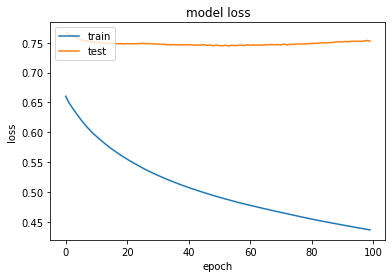

In [37]:
# summarize history for loss
plt.plot(classifier.history.history['loss'])
plt.plot(classifier.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [40]:
classifier.save('./models/bestmodel')

2021-08-23 10:02:52.768761: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./models/bestmodel/assets


In [38]:
#model = load_model('./Saved Models/model360-2509-653.h5')
# model = load_model('bestmodel.h5')
# model.summary()
model = classifier

In [42]:
model = load_model('./models/bestmodel')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               246272    
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_6 (Dense)              (None, 512)               5

In [39]:
#Accuracy of test set
y_pred = model.predict(X_test_scaled)
y_pred = (y_pred > 0.5)
print(boldTextStart,'Accuracy:',boldTextEnd)
accuracy_model = accuracy_score(y_test, y_pred, normalize=True)*100
print(accuracy_model,' %')
print(boldTextStart,'Confusion Matrix:',boldTextEnd)
print(confusion_matrix(y_test,y_pred))
print(boldTextStart,'Classification Report:',boldTextEnd)
print(classification_report(y_test,y_pred))
auc = roc_auc_score(y_test,y_pred)
print(boldTextStart,'AUC Score: ',boldTextEnd, auc)

 Accuracy: 
53.333333333333336  %
 Confusion Matrix: 
[[1 7]
 [0 7]]
 Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.12      0.22         8
           1       0.50      1.00      0.67         7

    accuracy                           0.53        15
   macro avg       0.75      0.56      0.44        15
weighted avg       0.77      0.53      0.43        15

 AUC Score:   0.5625


In [43]:
y_pred = model.predict(X_test_scaled)

In [55]:
np.where(y_pred > 0.5 , 1 , 0)[-1]

array([1])